# Titanic Survival Prediction 
# @ CodeSoft

### Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')


### Load the dataset

In [8]:
train_data = pd.read_csv('train.csv')  # Assuming you've downloaded train.csv from Kaggle
test_data = pd.read_csv('test.csv')    # Test data for final submission (optional)

### Exploratory Data Analysis (EDA)

In [9]:
print("Train Data Shape:", train_data.shape)
print("\nMissing Values:")
print(train_data.isnull().sum())
print("\nData Types:")
print(train_data.dtypes)

Train Data Shape: (891, 12)

Missing Values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Data Types:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


### Visualizations

In [10]:
plt.figure(figsize=(12, 8))


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

### Survival by Sex

Text(0.5, 1.0, 'Survival by Gender')

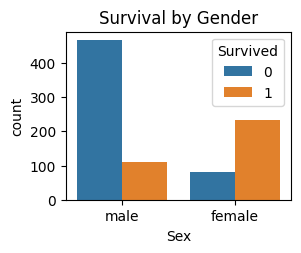

In [11]:
plt.subplot(2, 2, 1)
sns.countplot(x='Sex', hue='Survived', data=train_data)
plt.title('Survival by Gender')

### Survival by Pclass

Text(0.5, 1.0, 'Survival by Passenger Class')

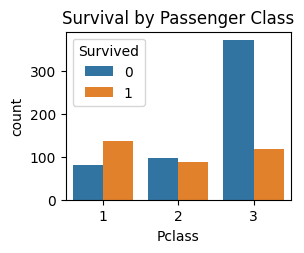

In [12]:
plt.subplot(2, 2, 2)
sns.countplot(x='Pclass', hue='Survived', data=train_data)
plt.title('Survival by Passenger Class')

### Age distribution of survivors vs non-survivors

Text(0.5, 1.0, 'Age Distribution of Survivors vs Non-Survivors')

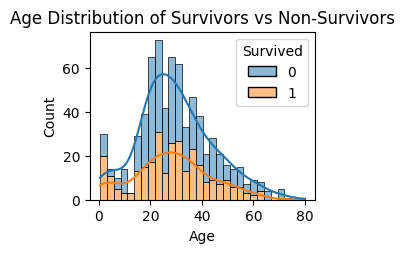

In [13]:
plt.subplot(2, 2, 3)
sns.histplot(data=train_data, x='Age', hue='Survived', bins=30, kde=True, multiple='stack')
plt.title('Age Distribution of Survivors vs Non-Survivors')

### Fare distribution

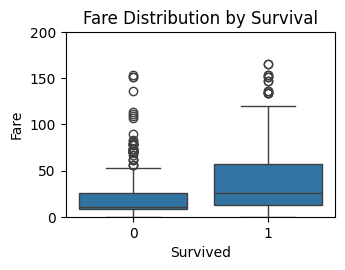

In [15]:
plt.subplot(2, 2, 4)
sns.boxplot(x='Survived', y='Fare', data=train_data)
plt.ylim(0, 200)  # Limit y-axis to better visualize most fares
plt.title('Fare Distribution by Survival')

plt.tight_layout()
plt.show()

### Feature Engineering

In [16]:
def feature_engineering(df):
    # Create a copy to avoid SettingWithCopyWarning
    df = df.copy()

### Extract titles from names

In [ ]:
# Extract titles from names
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 
                                      'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 60, 100], labels=[1, 2, 3, 4, 5])
    
    df['FareBin'] = pd.qcut(df['Fare'], 4, labels=[1, 2, 3, 4])
    
    df['HasCabin'] = (~df['Cabin'].isnull()).astype(int)
    
    df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    
    return df

### Apply feature engineering

In [23]:
train_data_eng = feature_engineering(train_data)

### Separate features and target

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin', 'IsAlone', 'HasCabin']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Feature selection and modeling pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=20)),
    ('classifier', RandomForestClassifier(random_state=42))])

# Model training
pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('feature_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Model evaluation


Model Accuracy: 0.8268156424581006

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       105
           1       0.79      0.78      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



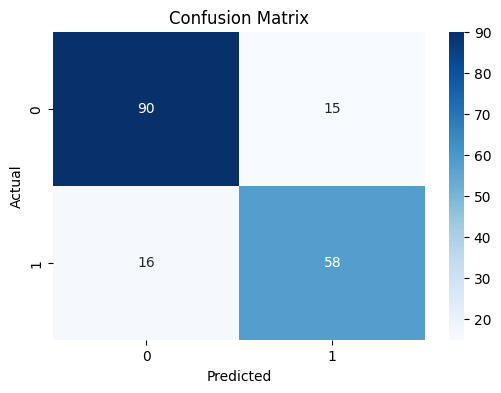

In [26]:
y_pred = pipeline.predict(X_val)
print("\nModel Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
preprocessor.fit(X_train)
feature_names = numeric_features + list(pipeline.named_steps['preprocessor']
                                      .named_transformers_['cat']
                                      .named_steps['onehot']
                                      .get_feature_names_out(categorical_features))



### Get selected features

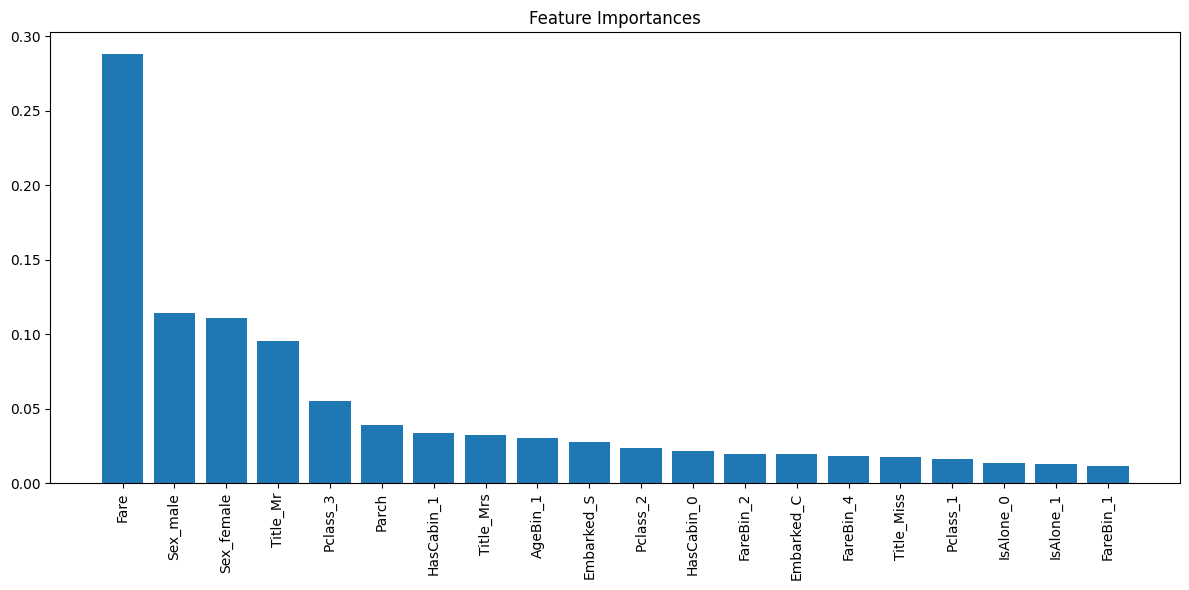

In [27]:
selected_features = pipeline.named_steps['feature_selection'].get_support()
selected_feature_names = [f for f, s in zip(feature_names, selected_features) if s]

importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(selected_feature_names)), importances[indices[:len(selected_feature_names)]])
plt.xticks(range(len(selected_feature_names)), 
           [selected_feature_names[i] for i in indices[:len(selected_feature_names)]], 
           rotation=90)
plt.tight_layout()
plt.show()


### Hyperparameter Tuning (Optional)

In [34]:
# Hyperparameter Tuning (Optional)
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'feature_selection__k': [15, 20, 25]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_val)
print("\nBest Model Accuracy:", accuracy_score(y_val, y_pred_best))
print("\nBest Model Classification Report:")
print(classification_report(y_val, y_pred_best))

# Prepare test data for submission (optional)
if not test_data.empty:
    test_data_eng = feature_engineering(test_data)
    test_passenger_ids = test_data['PassengerId']
    
    # Make predictions
    test_predictions = best_model.predict(test_data_eng)
    
    # Create submission file
    submission = pd.DataFrame({
        'PassengerId': test_passenger_ids,
        'Survived': test_predictions
    })
    
    submission.to_csv('titanic_submission.csv', index=False)
    print("\nSubmission file created: titanic_submission.csv")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'feature_selection__k': 25}
Best Score: 0.8300108342361863

Best Model Accuracy: 0.8156424581005587

Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



ValueError: Expected 2D array, got scalar array instead:
array=None.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.